# Attempting to extract params from multi-layered samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.LayeredExtractor import LayeredExtractor, LayeredExtractorNK

[((3.46+0.01j), 0.001), ((2.5+0.015j), 0.0005)]


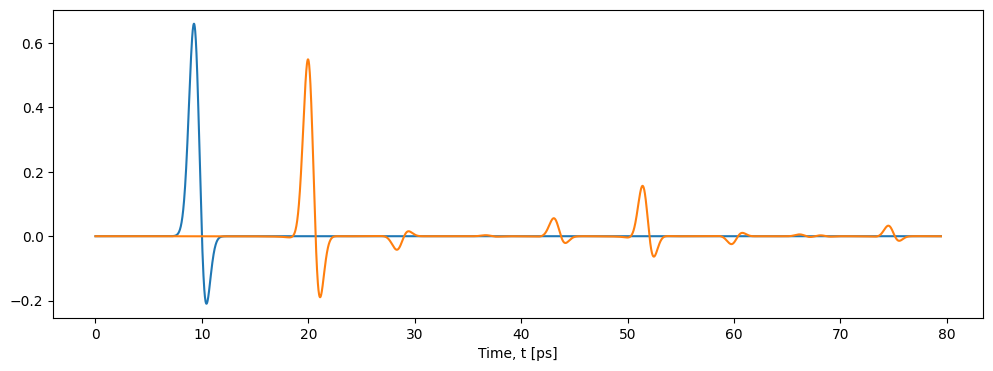

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 1e-3
n2, k2, d2= 2.5, 0.015, 0.5e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

## Test General model to fit all 3 parameters

Optimizing for 150 iterations with loss multiplier 1.
Iteration 0, Loss: 0.08746492862701416, Layer 0: n=3.440999984741211, k=0.0139999995008111, D=0.001098900567740202, Layer 1: n=2.4010000228881836, k=0.01600000075995922, D=0.0009990005055442452
Iteration 10, Loss: 0.08101881295442581, Layer 0: n=3.4511008262634277, k=0.004233494866639376, D=0.001099857734516263, Layer 1: n=2.411069631576538, k=0.006234185770153999, D=0.0009934284025803208
Iteration 20, Loss: 0.07676204293966293, Layer 0: n=3.4610166549682617, k=-0.0047714924439787865, D=0.0011103975120931864, Layer 1: n=2.4211623668670654, k=-0.00276104174554348, D=0.0009971634717658162
Iteration 30, Loss: 0.0738215520977974, Layer 0: n=3.4695494174957275, k=-0.012839292176067829, D=0.001119927503168583, Layer 1: n=2.4305307865142822, k=-0.010813848115503788, D=0.0010057402541860938
Iteration 40, Loss: 0.07170788198709488, Layer 0: n=3.4760186672210693, k=-0.020033488050103188, D=0.0011256234720349312, Layer 1: n=2.438883066177368, 

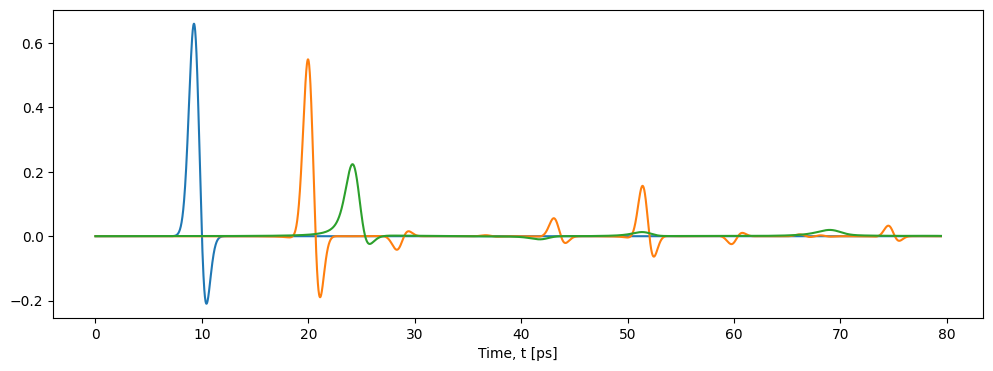

In [3]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

layers_init = [(3.44+1j*0.015, 1.1e-3), (2.4+1j*0.017, 1e-3)]


LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_init, lr=0.001)
nj,kj,dj = LE.optimize(num_iterations=150, updates=10, alpha=1)

optim_params = [(nj[0]+1j*kj[0], dj[0]), (nj[1]+1j*kj[1], dj[1])]

_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

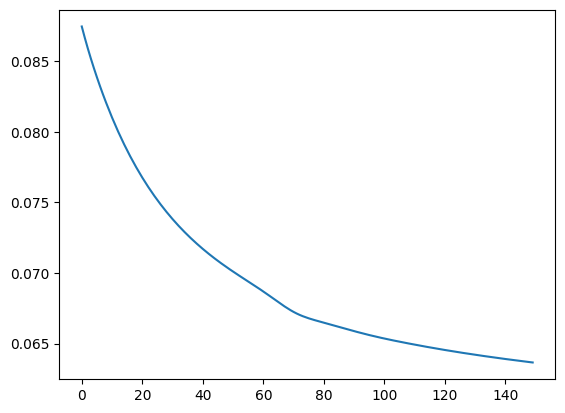

In [4]:
plt.plot(LE.loss_history)

## Fit just n's and k's for known d values

Optimizing n and k with initial conditions [((3.44+0.015j), 0.001), ((2.4+0.017j), 0.0005)]
Optimizing for 150 iterations with loss multiplier 100.
Iteration 0, Loss: 3.459416627883911, Layer 0: n=3.440999984741211, k=0.0139999995008111, D=0.001, Layer 1: n=2.4010000228881836, k=0.01600000075995922, D=0.0005
Iteration 10, Loss: 2.5223076343536377, Layer 0: n=3.4510021209716797, k=0.0045277732424438, D=0.001, Layer 1: n=2.4110074043273926, k=0.0065004900097846985, D=0.0005
Iteration 20, Loss: 1.9121193885803223, Layer 0: n=3.4608957767486572, k=-0.0016113988822326064, D=0.001, Layer 1: n=2.420931339263916, k=0.00016498897457495332, D=0.0005
Iteration 30, Loss: 1.4123106002807617, Layer 0: n=3.4704227447509766, k=-0.0009696492925286293, D=0.001, Layer 1: n=2.430542469024658, k=0.00036653256393037736, D=0.0005
Iteration 40, Loss: 0.7765366435050964, Layer 0: n=3.4795687198638916, k=0.006134934723377228, D=0.001, Layer 1: n=2.4399006366729736, k=0.007022230885922909, D=0.0005
Iteration 50,

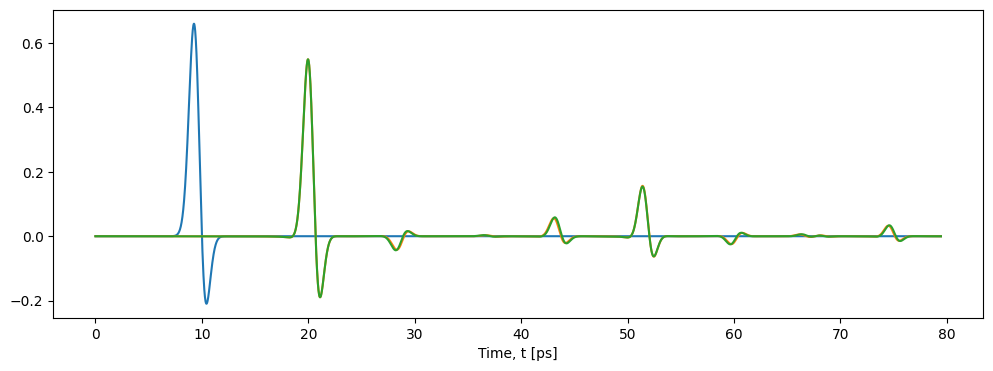

In [5]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

layers_nk_init = [(3.44+1j*0.015, 1e-3), (2.4+1j*0.017, 0.5e-3)]

LE_nk = LayeredExtractorNK(reference_pulse, experimental_pulse, deltat, layers_nk_init, lr=0.001)
print(f'Optimizing n and k with initial conditions {layers_nk_init}')
nj, kj = LE_nk.optimize(num_iterations=150, updates=10, alpha=100)

optim_params = [(nj[0]+1j*kj[0], d1), (nj[1]+1j*kj[1], d2)]

_, optimal_pulse_nk = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse_nk = optimal_pulse_nk[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.plot(t_axis*1e12, optimal_pulse_nk.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

In [6]:
optim_params

[((3.474473237991333+0.009829235263168812j), 0.001),
 ((2.470299482345581+0.015366919338703156j), 0.0005)]

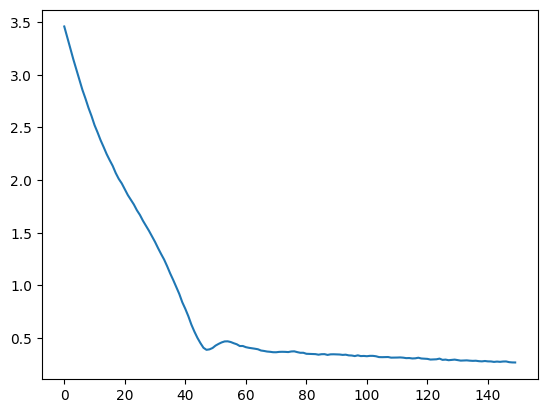

In [7]:
plt.plot(LE_nk.loss_history)